# TODO:
- Arreglar dtypes
- Aplicar tratamiento datos separados por categoricas y no
- usar filtro Feto para gemelos
- features selection > GWG tenga mas importancia
- reparar desbalancea de clases (modelamiento)
- benchamark de modelos > guardar modelo ganador 
- guardar error promedio > para calcular intervalo de confianza
- reporte de benchmark modelos
- reporte de var importance (modelo ganador)
- programar heuristica de optimización
- programar intervalo de confianza

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Packages

In [2]:
!pip install statsmodels
!pip install matplotlib
!pip install seaborn
!pip install lxml
!pip install openpyxl

In [64]:
import os
import sys
from pathlib import Path
import pickle

from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import plot_confusion_matrix

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
    
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

In [4]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils.preprocess import fix_binaries, fix_dttms

# Statics

In [5]:
PATH_REPO = Path(os.getcwd()).parent
PATH_RAW_DATA = PATH_REPO / "data/input/00_raw.csv"
PATH_PROCESS_DATA = PATH_REPO / "data/input/01_process.csv"
PATH_CATALOG = PATH_REPO / "statics/globals/catalog.xlsx"
NUMERICS = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Load Data

In [6]:
catalog = pd.read_excel(PATH_CATALOG)
raw_data = pd.read_csv(PATH_RAW_DATA, sep=";", low_memory=False, usecols=catalog["name"].tolist())
raw_data

,rut,poblbarr_a,comuna_a,edad_a,consorig_a,previsio_a,estudio_a,est_civil_a,activida_a,paf_no_a,paf_diab_a,paf_tbcp_a,paf_hipe_a,paf_aler_a,pam_no_a,pam_diab_a,pam_tbcp_a,pam_hipe_a,pam_aler_a,pam_asma_a,pam_epil_a,pam_tiro_a,pam_card_a,pam_rena_a,paq_no_a,paq_cono_a,paq_miom_a,paq_infe_a,paq_liti_a,paq_cole_a,paq_apen_a,mecr_no_a,mecr_dur_a,mecr_des_a,mecr_nos_a,mecrcual_a,cigardia_a,alcohol_a,dro_no_a,dro_coca_a,dro_mari_a,dro_past_a,dro_amfe_a,dro_benz_a,anticonc_a,otr_anti_a,epre_nor_a,epre_mal_a,epre_pree_a,epre_diab_a,epre_snc_a,epre_car_a,epre_dow_a,epre_otr_a,epre_otc_a,ae_a,ap_a,ppr_a,pter_a,mnat_a,mneo_a,hv_a,embecto_a,cesaprev_a,rnmaypes_a,embgeme_a,inicontp_a,pesonorm_a,nrocontr_a,talla_a,grpsanc_a,grpsanr_a,estnutri_a,fecha_b,pesoactu_b,edagest_e,nrofetos_e,fechapar_f,pate_hip_g,pate_dia_g,pesonac_g,tallanac_g,fallece_g
0,81981833,LA ESPERANZA,PUENTE ALTO,39.0,PARTICULAR,4.0,5.0,1.0,5.0,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,VERDADERO,FALSO,NaN,1.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,2.0,NaN,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,NaN,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,4370.0,0.0,8.0,108.0,9.0,168,1.0,1.0,4.0,25-03-02,NaN,"37,6",1.0,25-03-02,FALSO,FALSO,3670.0,510.0,FALSO
1,15183309,V. NOCEDAL,PUENTE ALTO,24.0,SAN GERONIMO,6.0,3.0,2.0,2.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,NaN,1.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,4.0,NaN,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3280.0,0.0,12.0,64.0,6.0,155,1.0,2.0,3.0,13-05-02,73.0,"38,2",1.0,13-05-02,FALSO,FALSO,3520.0,495.0,FALSO
2,13592116,POB. EL RODEO,LA FLORIDA,28.0,LOS QUILLAYES,6.0,3.0,3.0,2.0,FALSO,VERDADERO,FALSO,VERDADERO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,NaN,1.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,4.0,NaN,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,46.0,12.0,149,1.0,1.0,2.0,06-03-02,61.0,39,1.0,07-03-02,FALSO,FALSO,3390.0,520.0,FALSO
3,14046007,V. PERPETUO FREIRE,LA FLORIDA,24.0,MAFFIOLETTI,1.0,4.0,3.0,2.0,FALSO,VERDADERO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,NaN,3.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,3.0,NaN,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,58.0,6.0,155,1.0,1.0,4.0,01-03-02,75.0,"38,1",1.0,02-03-02,FALSO,FALSO,2960.0,475.0,FALSO
4,12676061,POB. NVO. AMANECER,LA FLORIDA,25.0,LOS CASTAÃ‘OS,1.0,3.0,1.0,2.0,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,NaN,1.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,2.0,NaN,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3770.0,0.0,22.0,53.0,6.0,161,1.0,1.0,2.0,26-04-02,70.0,41,1.0,26-04-02,FALSO,FALSO,4030.0,510.0,FALSO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113063,001666118,EUGENIO MATTE,PUENTE ALTO,32.0,ALEJANDRO DEL RIO,1.0,2.0,1.0,2.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,NaN,1.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,4.0,NaN,FALSO,FALSO,FALS

# Preprocess

- Var Fixs:
    1. [ok] Fix Binaries
    2. [ok] Fix dttms
- Filters & Drops
    1. [ok] Twins Filter (rows) > drop col
    2. [ok] Birth Date (rows)
    2. [ok] Missing Values (columns)
    3. [ok] STD (columns)
- Create
    1. [ok] IMC $= \dfrac{pesonorm_a (kg)}{talla_a^2 (m)}$
    2. [ok] GWG $= pesoactu_b - pesonorm_a$
    3. [ok] LGA $pesonac_g > P_{90}$
    4. [ok] SGA = $pesonac_g < P_{10}$
- Transform
    1. [ok] MVI
    2. [ok] Hot Encoding (pickle)
    3. [ok] Outliers (pickle)

## Var Fixs

In [7]:
data_fix = raw_data.copy()
# 1. boolean var fix
bin_cols = catalog.loc[catalog["type"]=="boolean","name"]
for c in bin_cols:
    data_fix[c] = data_fix[c].apply(lambda x: fix_binaries(x))
display(data_fix[bin_cols])
# 2. dtts fix
dtts_cols = catalog.loc[catalog["type"]=="dttm","name"]
for c in dtts_cols:
    data_fix[c] = data_fix[c].apply(lambda x: fix_dttms(x))
display(data_fix[dtts_cols])

,paf_no_a,paf_diab_a,paf_tbcp_a,paf_hipe_a,paf_aler_a,pam_no_a,pam_diab_a,pam_tbcp_a,pam_hipe_a,pam_aler_a,pam_asma_a,pam_epil_a,pam_tiro_a,pam_card_a,pam_rena_a,paq_no_a,paq_cono_a,paq_miom_a,paq_infe_a,paq_liti_a,paq_cole_a,paq_apen_a,mecr_no_a,mecr_dur_a,mecr_des_a,mecr_nos_a,mecrcual_a,dro_no_a,dro_coca_a,dro_mari_a,dro_past_a,dro_amfe_a,dro_benz_a,anticonc_a,epre_nor_a,epre_mal_a,epre_pree_a,epre_diab_a,epre_snc_a,epre_car_a,epre_dow_a,epre_otr_a,epre_otc_a,embgeme_a,pate_hip_g,pate_dia_g,fallece_g
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113063,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
113064,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
113065,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
113066,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN


,fecha_b,fechapar_f
0,2002-03-25,2002-03-25
1,2002-05-13,2002-05-13
2,2002-03-06,2002-03-07
3,2002-03-01,2002-03-02
4,2002-04-26,2002-04-26
...,...,...
113063,NaT,NaT
113064,NaT,NaT
113065,NaT,NaT
113066,NaT,NaT


## Filters & Drops

In [120]:
data_filter = data_fix.copy()
counter = 0
ni = len(data_filter)

# 1. Twins Filter (rows) > drop col
twin_col = "embgeme_a" # TODO: hacerlo con nrofetos_e
mask = ~(data_filter[twin_col] > 0)
data_filter = data_filter[mask]
data_filter.drop(columns=[twin_col, "nrofetos_e"], inplace=True)
nf  = len(data_filter)
print("total rows after twins filter: {} / {} ({}%)\n".format(nf,ni,nf*100/ni))

# 2. Birth Date (rows)
th_upper=31
th_lower=0
data_filter["_diff_days"] =  data_filter.apply(lambda x: (x["fechapar_f"] - x["fecha_b"]).days, axis=1)
ni = len(data_filter)
data_filter = data_filter.loc[(data_filter["_diff_days"] < 31) & (data_filter["_diff_days"] >= 0), :]
data_filter.drop(columns=["_diff_days", "fechapar_f", "fecha_b"], inplace=True)
nf = len(data_filter)
print("total rows after Birth Date filter: {} / {} ({}%)\n".format(nf,ni,nf*100/ni))

# 3. Missing Values (columns) +numerics +categorics
th = 0.2
for c in data_filter.columns:
    if data_filter[c].isna().mean() > th:
        counter +=1
        print("({}) Dropping {} due missing values".format(counter, c))
        data_filter.drop(columns=[c], inplace=True)
print("\n Missing values report")
display(data_filter.isna().mean().sort_values(ascending=False))

# 4. STD (columns)
th = 0
for c in data_filter.select_dtypes(include=NUMERICS).columns:
    if data_filter[c].std() <= th:
        counter +=1
        print("({}) Dropping {} due std".format(counter, c))
        data_filter.drop(columns=[c], inplace=True)
print("\n STD report")
display(data_filter.select_dtypes(include=NUMERICS).std().sort_values(ascending=True))


total rows after twins filter: 112613 / 113068 (99.59758729260268%)

total rows after Birth Date filter: 97158 / 112613 (86.2760072105352%)

(1) Dropping mecrcual_a due missing values
(2) Dropping otr_anti_a due missing values
(3) Dropping epre_otc_a due missing values
(4) Dropping embecto_a due missing values
(5) Dropping cesaprev_a due missing values
(6) Dropping rnmaypes_a due missing values

 Missing values report


poblbarr_a    0.162900
pesonorm_a    0.082742
pesoactu_b    0.072995
talla_a       0.054468
nrocontr_a    0.045750
                ...   
mecr_no_a     0.013627
mecr_dur_a    0.013627
mecr_des_a    0.013627
mecr_nos_a    0.013627
rut           0.000000
Length: 73, dtype: float64


 STD report


dro_amfe_a      0.011646
epre_dow_a      0.022606
dro_benz_a      0.022606
pate_dia_g      0.027495
paq_infe_a      0.027777
                 ...    
edad_a         10.211412
pesoactu_b     16.571240
pesonorm_a     29.488398
tallanac_g     77.626516
pesonac_g     599.153998
Length: 67, dtype: float64

## Create new cols
1. IMC $= \dfrac{pesonorm_a (kg)}{talla_a^2 (m)}$
2. GWG $= pesoactu_b - pesonorm_a$
3. LGA $pesonac_g > P_{90}$
4. SGA = $pesonac_g < P_{10}$

In [121]:
def pre_edagest_e(x):
    x_ = str(x).split(",")[0]
    if not x_.isnumeric():
        return
    else:
        return int(x_)
def get_imc(pesonorm_a,talla_a):
    pesonorm_a = float(str(pesonorm_a).replace(",", ".").replace(" ", ""))
    talla_a = float(str(talla_a).replace(",", ".").replace(" ", ""))
    if talla_a == 0.0:
        return
    return float(pesonorm_a)/(float(talla_a)*0.01)**2

In [122]:
data_news = data_filter.copy()
cols_drops = ["pesonorm_a", "talla_a", "pesoactu_b", "pesonorm_a", "edagest_e"]
new_cols = ["IMC", "GWG", "LGA", "SGA"]
data_news["IMC"] = data_news.apply(lambda x: get_imc(x.pesonorm_a,x.talla_a), axis=1)
data_news["GWG"] = data_news["pesoactu_b"]-data_news["pesonorm_a"]

data_news["edagest_e"] = data_news["edagest_e"].apply(lambda x: pre_edagest_e(x))
q_lga = data_news["edagest_e"].quantile(0.9)
q_sga = data_news["edagest_e"].quantile(0.1)

data_news["LGA"] = data_news["edagest_e"].apply(lambda x: int(x>=q_lga))
data_news["SGA"] = data_news["edagest_e"].apply(lambda x: int(x<=q_sga))
data_news.drop(columns=cols_drops, inplace=True)
data_news[new_cols].describe()

,IMC,GWG,LGA,SGA
count,88130.000000,83350.000000,97158.000000,97158.000000
mean,37.168913,12.112513,0.309630,0.105828
std,2147.353176,29.469788,0.462343,0.307618
min,0.000000,-893.000000,0.000000,0.000000
25%,22.189349,9.000000,0.000000,0.000000
50%,24.747454,13.000000,0.000000,0.000000
75%,28.398718,17.000000,1.000000,0.000000
max,630000.000000,837.000000,1.000000,1.000000


## Transform + Bonus = extra drops and fix comuna

In [123]:
def clean_str(val):
    specials = {"ã‘uã‘oa": "ñuñoa", "peã‘alolen": "peñalolen", "otra regiã³n": "otra región", "estaciã“n central": "estación central"}
    spanish = {"ñ": "n", "á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u"}
    if not isinstance(val, str):
        return val
    val_ = val.lower()
    if val_ in specials:
        val_ = specials[val_]
    
    for k in spanish:
        val_.replace(k, spanish[k])
    
    return val_

### Get Comunas

In [124]:
comuna_name = "comuna_a"
path = PATH_REPO / "data/models/comunas.pkl"
comunas = data_news[comuna_name].apply(lambda x: clean_str(x)).unique().tolist()
with open(path, "wb") as file_to_store:
    pickle.dump(comunas, file_to_store)

### Continue Transform

In [125]:
data_t = data_news.copy()
extra_drops = ["poblbarr_a", "consorig_a", "rut"]
data_t.drop(columns=extra_drops, inplace=True)

# MVI
numeric_imputer = SimpleImputer(strategy='mean')
numeric_features = data_t.select_dtypes(include=NUMERICS).columns
data_t[numeric_features] = numeric_imputer.fit_transform(data_t[numeric_features])

categoric_imputer = SimpleImputer(strategy='most_frequent')
categoric_features = data_t.select_dtypes(exclude=NUMERICS).columns
data_t[categoric_features] = categoric_imputer.fit_transform(data_t[categoric_features])

display(data_t.isna().mean().sort_values(ascending=False))

# Fix Comuna
for c in categoric_features:
    data_t[c] = data_t[c].apply(lambda x: clean_str(x))
data_t[categoric_features]

# Outliers (pickle)

for c in data_t.select_dtypes(include=NUMERICS).columns:
    
    if data_t[c].max() == 1 and data_t[c].min() == 0:
        print("Skipping column {} due to a binary".format(c))
        continue
    
    std = data_t[c].std()
    mean = data_t[c].mean()
    
    upper = mean + 2*std
    lower = mean - 2*std
    
    mask = (data_t[c] < lower) | (data_t[c] > upper)
    n_ol = len(data_t[mask])
    
    data_t.loc[mask, c] = mean
    
    mask_post = (data_t[c] < lower) | (data_t[c] > upper)
    n_ol_post = len(data_t[mask_post])
    
    print("Column {} have {} / {} ({} %) of data as outliers.".format(c, n_ol, len(data_t),n_ol / len(data_t)))
    print("upper: {}, lower: {}, mean: {}".format( upper, lower, mean))
    print("\t Now is: {} %".format(n_ol_post / len(data_t)))

# Hot Encoding (pickle)

data_t.reset_index(inplace=True, drop=True)
for c in categoric_features:
    enc_name = "{}_oneHotEncoder".format(c)
    path = PATH_REPO / "data/models/{}.pkl".format(enc_name)
    enc = OneHotEncoder(drop='first', min_frequency=0.01)
    one_hot_values =  pd.DataFrame(enc.fit_transform(data_t[categoric_features]).toarray(), columns=enc.get_feature_names_out())
    data_t.drop(columns=[c], inplace=True)
    data_t = data_t.join(one_hot_values)
    with open(path, "wb") as file_to_store:
        pickle.dump(enc, file_to_store)

data_t

comuna_a       0.0
epre_diab_a    0.0
ap_a           0.0
ae_a           0.0
epre_otr_a     0.0
              ... 
mecr_dur_a     0.0
mecr_des_a     0.0
mecr_nos_a     0.0
cigardia_a     0.0
SGA            0.0
Length: 70, dtype: float64

Column edad_a have 7160 / 97158 (0.07369439469729719 %) of data as outliers.
upper: 47.514194847650444, lower: 6.94781237316889, mean: 27.231003610409665
	 Now is: 0.0 %
Column previsio_a have 7244 / 97158 (0.07455896580827107 %) of data as outliers.
upper: 5.268593344564266, lower: -0.859657058903645, mean: 2.2044681428303106
	 Now is: 0.0 %
Column estudio_a have 8267 / 97158 (0.08508820683834578 %) of data as outliers.
upper: 4.461399227359742, lower: 1.063111906475849, mean: 2.7622555669177955
	 Now is: 0.0 %
Column est_civil_a have 2759 / 97158 (0.02839704399020153 %) of data as outliers.
upper: 3.762599439439187, lower: 0.2380266431619773, mean: 2.0003130413005823
	 Now is: 0.0 %
Column activida_a have 621 / 97158 (0.0063916507132711665 %) of data as outliers.
upper: 6.2715585592579135, lower: -0.6589158645983972, mean: 2.806321347329758
	 Now is: 0.0 %
Skipping column paf_no_a due to a binary
Skipping column paf_diab_a due to a binary
Skipping column paf_tbcp_a due to a binary
Sk

,edad_a,previsio_a,estudio_a,est_civil_a,activida_a,paf_no_a,paf_diab_a,paf_tbcp_a,paf_hipe_a,paf_aler_a,pam_no_a,pam_diab_a,pam_tbcp_a,pam_hipe_a,pam_aler_a,pam_asma_a,pam_epil_a,pam_tiro_a,pam_card_a,pam_rena_a,paq_no_a,paq_cono_a,paq_miom_a,paq_infe_a,paq_liti_a,paq_cole_a,paq_apen_a,mecr_no_a,mecr_dur_a,mecr_des_a,mecr_nos_a,cigardia_a,alcohol_a,dro_no_a,dro_coca_a,dro_mari_a,dro_past_a,dro_amfe_a,dro_benz_a,anticonc_a,epre_nor_a,epre_mal_a,epre_pree_a,epre_diab_a,epre_snc_a,epre_car_a,epre_dow_a,epre_otr_a,ae_a,ap_a,ppr_a,pter_a,mnat_a,mneo_a,hv_a,inicontp_a,nrocontr_a,grpsanc_a,grpsanr_a,estnutri_a,pate_hip_g,pate_dia_g,pesonac_g,tallanac_g,fallece_g,IMC,GWG,LGA,SGA,comuna_a_la pintana,comuna_a_pirque,comuna_a_puente alto,comuna_a_san jose maipo,comuna_a_infrequent_sklearn
0,39.000000,4.000000,2.762256,1.000000,5.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,0.000000,1.000000,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,8.000000,9.000000,1.000000,1.000000,4.00000,0.0,0.0,3670.000000,510.0,0.0,38.265306,12.112513,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,24.000000,2.204468,3.000000,2.000000,2.000000,1.000000,0.00000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,12.000000,6.000000,1.000000,2.000000,3.00000,0.0,0.0,3520.000000,495.0,0.0,26.638918,9.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,28.000000,2.204468,3.000000,3.000000,2.000000,0.000000,1.00000,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008891,0.008044,0.997105,12.000000,12.000000,1.000000,1.000000,2.00000,0.0,0.0,3390.000000,520.0,0.0,20.719787,15.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,24.000000,1.000000,4.000000,3.000000,2.000000,0.000000,1.00000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.187668,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008891,0.008044,0.997105,23.000000,6.000000,1.000000,1.000000,4.00000,0.0,0.0,2960.000000,475.0,0.0,24.141519,17.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25.000000,1.000000,3.000000,1.000000,2.000000,0.000000,0.00000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,22.000000,6.000000,1.000000,1.000000,2.00000,0.0,0.0,4030.000000,510.0,0.0,20.446742,17.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# Final and Save Data

In [126]:
# Rename
targets = ["LGA", "SGA", "hipertension", "diabetes"]
data_final = data_t.copy()
data_final.rename(columns={"pate_hip_g": "hipertension","pate_dia_g": "diabetes"}, inplace=True)
features = [c for c in data_final.columns if c not in targets]
data_final = data_final[targets + features]

path = PATH_REPO / "data/models/features_names.pkl" 
with open(path, "wb") as file_to_store:
    pickle.dump(features, file_to_store)

path = PATH_REPO / "data/models/targets_names.pkl" 
with open(path, "wb") as file_to_store:
    pickle.dump(targets, file_to_store)

    
data_final.to_csv(PATH_PROCESS_DATA)
data_final

,LGA,SGA,hipertension,diabetes,edad_a,previsio_a,estudio_a,est_civil_a,activida_a,paf_no_a,paf_diab_a,paf_tbcp_a,paf_hipe_a,paf_aler_a,pam_no_a,pam_diab_a,pam_tbcp_a,pam_hipe_a,pam_aler_a,pam_asma_a,pam_epil_a,pam_tiro_a,pam_card_a,pam_rena_a,paq_no_a,paq_cono_a,paq_miom_a,paq_infe_a,paq_liti_a,paq_cole_a,paq_apen_a,mecr_no_a,mecr_dur_a,mecr_des_a,mecr_nos_a,cigardia_a,alcohol_a,dro_no_a,dro_coca_a,dro_mari_a,dro_past_a,dro_amfe_a,dro_benz_a,anticonc_a,epre_nor_a,epre_mal_a,epre_pree_a,epre_diab_a,epre_snc_a,epre_car_a,epre_dow_a,epre_otr_a,ae_a,ap_a,ppr_a,pter_a,mnat_a,mneo_a,hv_a,inicontp_a,nrocontr_a,grpsanc_a,grpsanr_a,estnutri_a,pesonac_g,tallanac_g,fallece_g,IMC,GWG,comuna_a_la pintana,comuna_a_pirque,comuna_a_puente alto,comuna_a_san jose maipo,comuna_a_infrequent_sklearn
0,0.0,0.0,0.0,0.0,39.000000,4.000000,2.762256,1.000000,5.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,0.000000,1.000000,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,8.000000,9.000000,1.000000,1.000000,4.00000,3670.000000,510.0,0.0,38.265306,12.112513,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,24.000000,2.204468,3.000000,2.000000,2.000000,1.000000,0.00000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,12.000000,6.000000,1.000000,2.000000,3.00000,3520.000000,495.0,0.0,26.638918,9.000000,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,28.000000,2.204468,3.000000,3.000000,2.000000,0.000000,1.00000,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008891,0.008044,0.997105,12.000000,12.000000,1.000000,1.000000,2.00000,3390.000000,520.0,0.0,20.719787,15.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,24.000000,1.000000,4.000000,3.000000,2.000000,0.000000,1.00000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.187668,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008891,0.008044,0.997105,23.000000,6.000000,1.000000,1.000000,4.00000,2960.000000,475.0,0.0,24.141519,17.000000,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,25.000000,1.000000,3.000000,1.000000,2.000000,0.000000,0.00000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,22.000000,6.000000,1.000000,1.000000,2.00000,4030.000000,510.0,0.0,20.446742,17.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# Logit Model

,LGA,SGA,hipertension,diabetes
count,97158.000000,97158.000000,97158.000000,97158.000000
mean,0.309630,0.105828,0.005243,0.000757
std,0.462343,0.307618,0.071478,0.027212
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000



 Target: LGA
Accuracy: 72.14903252367229 %
Accuracy: 60.94432577697495 %


<AxesSubplot:>


 Target: SGA
Accuracy: 91.71469740634006 %
Accuracy: 66.24888166637848 %


<AxesSubplot:>


 Target: hipertension
Accuracy: 99.40819267188144 %
Accuracy: 53.664891863504984 %


<AxesSubplot:>


 Target: diabetes
Accuracy: 99.92280773981062 %
Accuracy: 49.994850404243266 %


<AxesSubplot:>

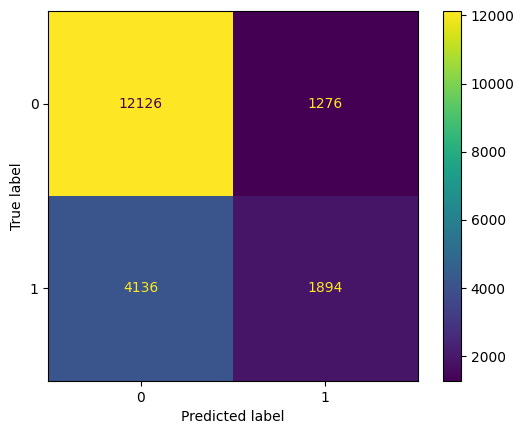

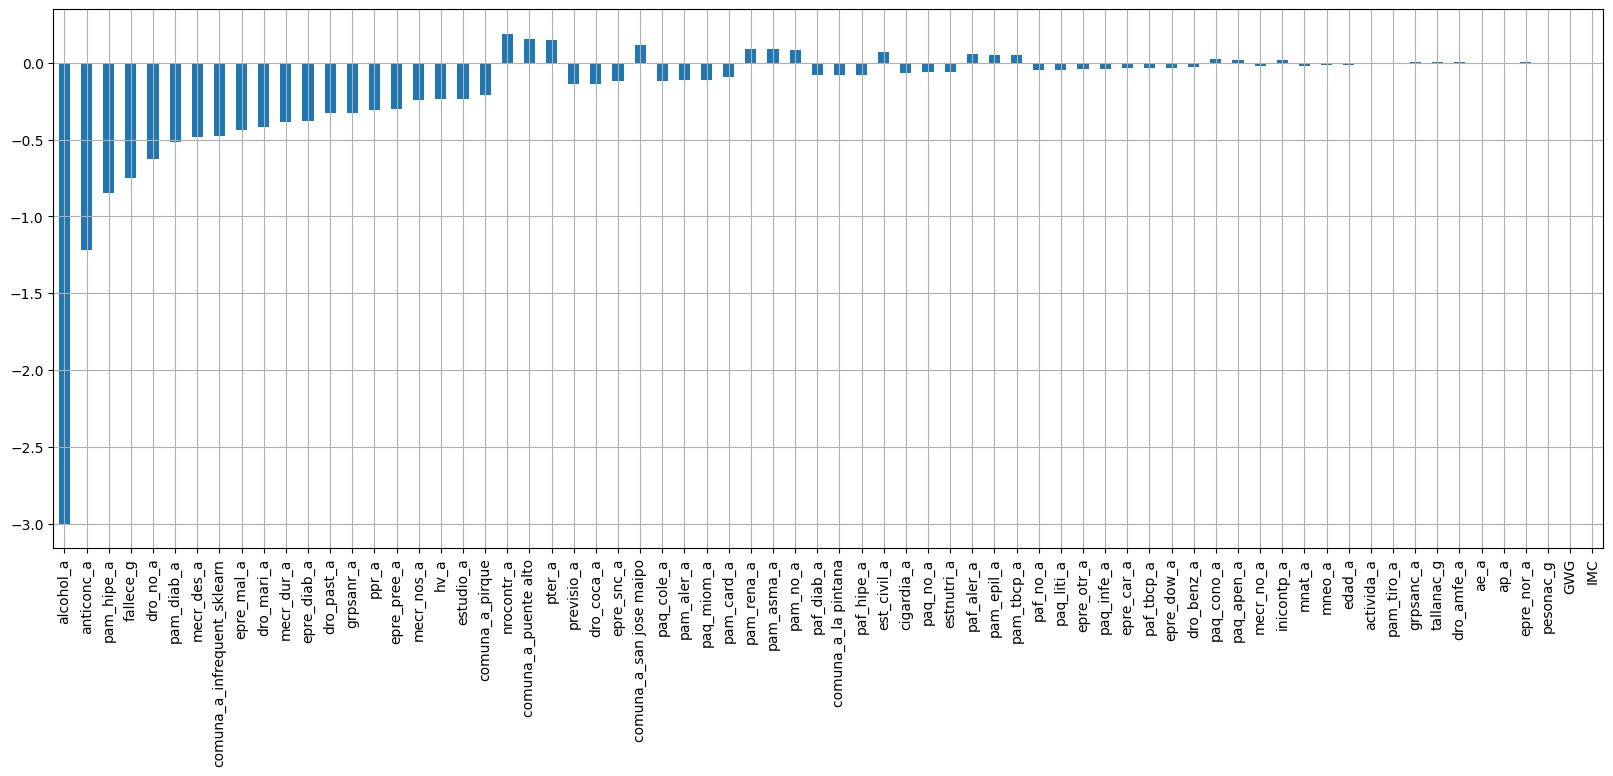

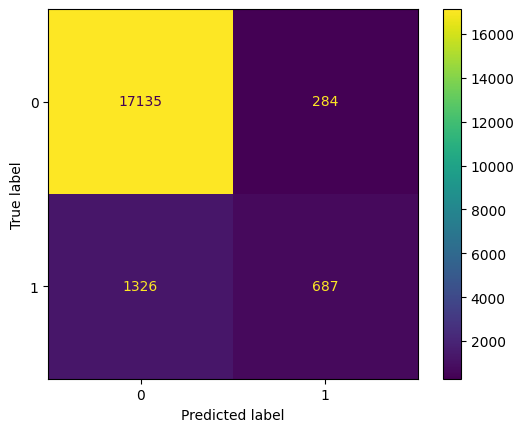

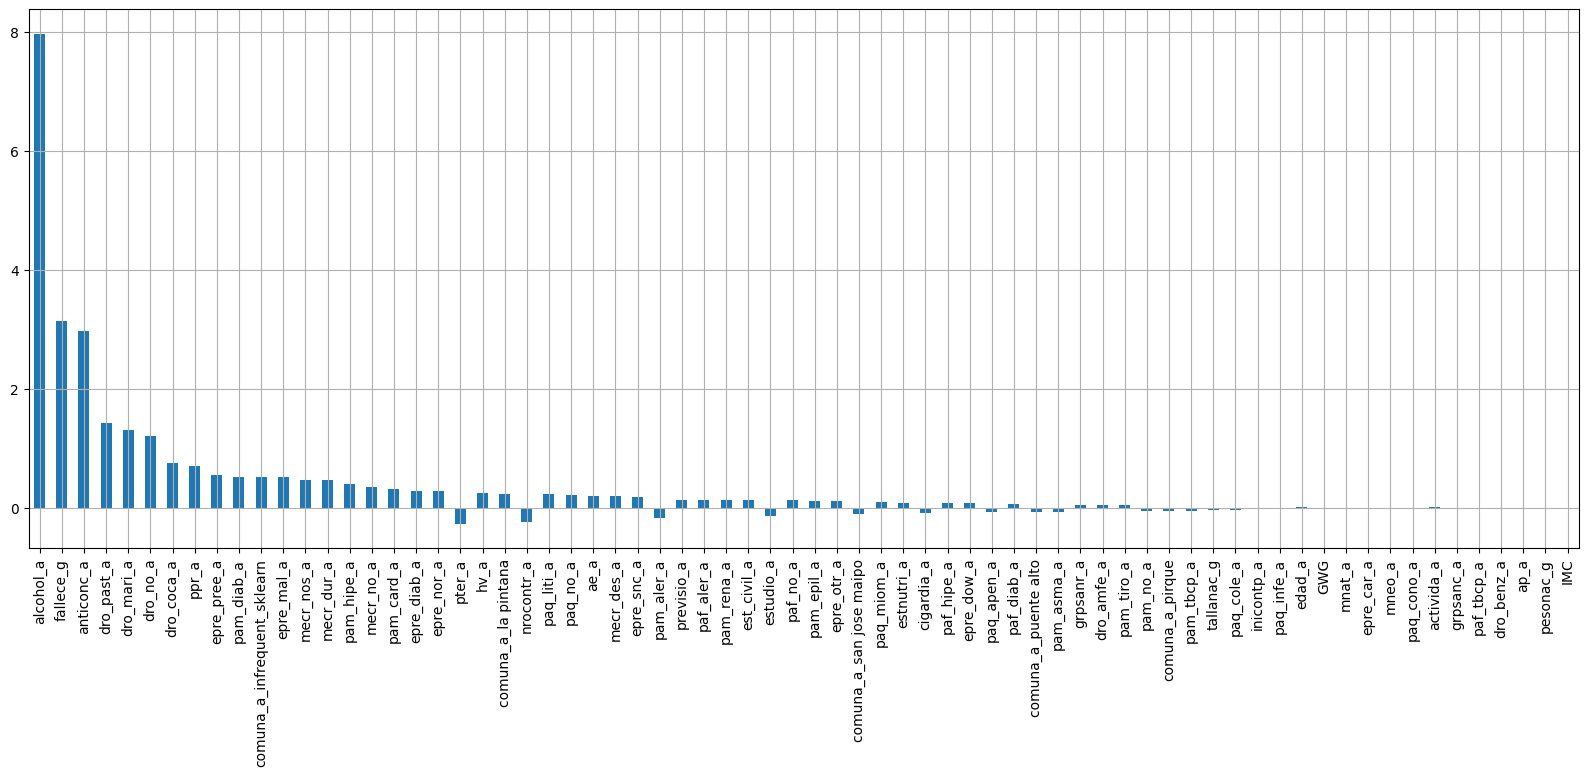

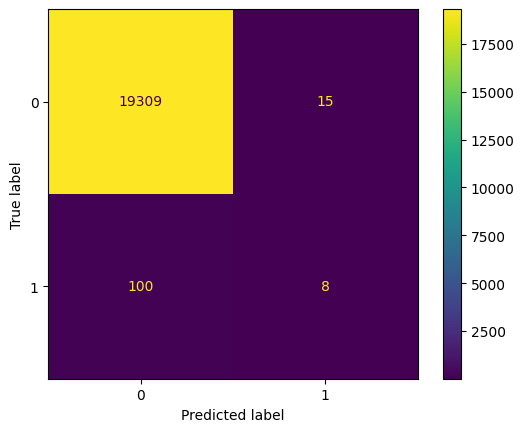

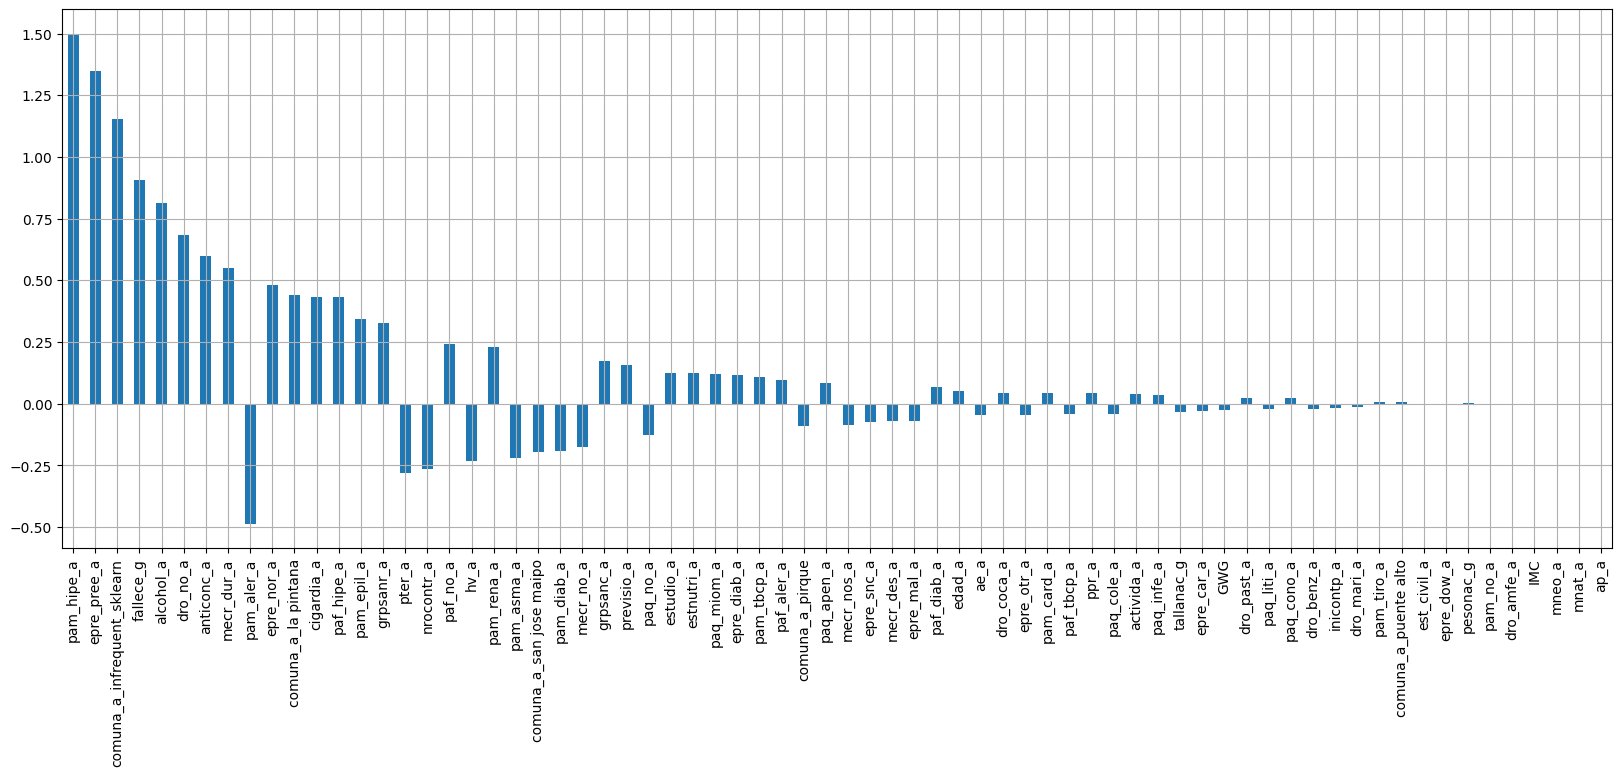

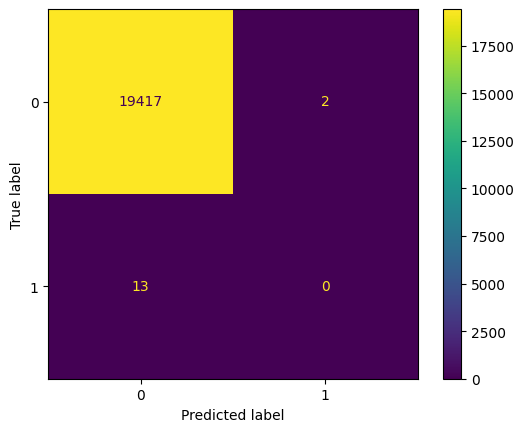

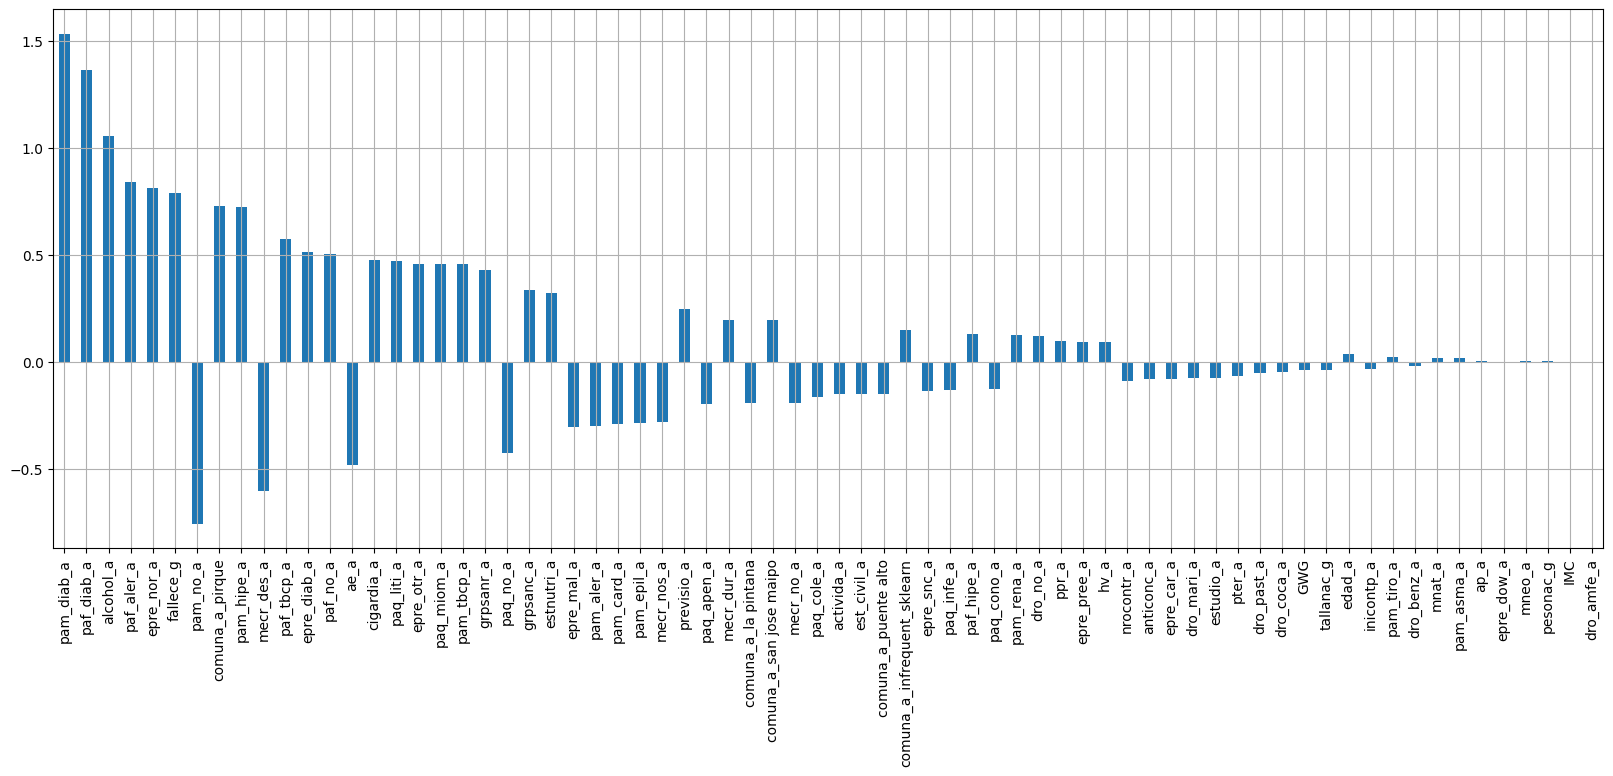

In [131]:
df = pd.read_csv(PATH_PROCESS_DATA, index_col=0)
features = pickle.load(open(PATH_REPO / "data/models/features_names.pkl", "rb"))
targets = pickle.load(open(PATH_REPO / "data/models/targets_names.pkl", "rb"))
display(df[targets].describe())

for t in targets:
    print("\n Target:", t)
    
    df_aux = df
    
    X = df[features]
    y = df[t].apply(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = LogisticRegression(random_state=1194, solver="liblinear").fit(X_train, y_train)
    print("Accuracy: {} %".format(clf.score(X_test, y_test)*100))
    y_pred = clf.predict(X_test)
    print("B. Accuracy: {} %".format(balanced_accuracy_score(y_test, y_pred)*100))
    display(plot_confusion_matrix(clf, X_test, y_test))
    
    var_imp = pd.DataFrame(clf.coef_, columns=features).T
    var_imp = var_imp.rename(columns={0:"val"})
    var_imp["abs"] = var_imp["val"].apply(abs)
    var_imp.sort_values(by=["abs"], ascending=False, inplace=True)
    display(var_imp.plot.bar(y="val", figsize=(20,7), legend=False, grid=True))